In [3]:
"""
Sales Forecast and Analysis - Complete Solution
Author: [Your Name]
Date: 2025-01-06

This project analyzes customer transaction data to understand behavior patterns
and predict future transactions. It includes EDA, visualizations, feature engineering,
and multiple ML models.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# ==================== 1. DATA LOADING AND CLEANING ====================

def load_and_clean_data():
    """
    Load transaction data from CSV files and perform initial cleaning.
    
    Returns:
    --------
    pd.DataFrame: Cleaned and combined transaction data
    """
    print("Loading transaction data...")
    
    # Load both CSV files
    df1 = pd.read_csv('dataset/transactions_1.csv')
    df2 = pd.read_csv('dataset/transactions_2.csv')
    
    # Combine datasets
    df = pd.concat([df1, df2], ignore_index=True)
    
    # Drop the unnamed index column
    if df.columns[0] == 'Unnamed: 0' or df.columns[0] == '':
        df = df.drop(columns=df.columns[0])
    
    # Ensure proper data types
    df['date'] = pd.to_datetime(df['date'])
    df['customer_id'] = df['customer_id'].astype(int)
    df['product_id'] = df['product_id'].astype(str)
    
    # Sort by date
    df = df.sort_values('date').reset_index(drop=True)
    
    # Add time-based features for analysis
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['quarter'] = df['date'].dt.quarter
    df['year_month'] = df['date'].dt.to_period('M')
    
    print(f"Total transactions loaded: {len(df):,}")
    print(f"Date range: {df['date'].min()} to {df['date'].max()}")
    print(f"Unique customers: {df['customer_id'].nunique():,}")
    print(f"Unique products: {df['product_id'].nunique():,}")
    
    return df

In [7]:
df = load_and_clean_data()


Loading transaction data...
Total transactions loaded: 975,955
Date range: 2017-01-01 08:32:26.307000+00:00 to 2020-03-17 00:08:21.430000+00:00
Unique customers: 2,002
Unique products: 50


In [4]:

def analyze_data_quality(df):
    """Analyze data quality and basic statistics."""
    print("\n=== Data Quality Analysis ===")
    print(f"Missing values:\n{df.isnull().sum()}")
    print(f"\nDuplicate transactions: {df.duplicated().sum()}")
    
    # Transaction frequency analysis
    print("\n=== Transaction Frequency ===")
    txn_per_customer = df.groupby('customer_id').size()
    print(f"Transactions per customer:")
    print(f"  Mean: {txn_per_customer.mean():.2f}")
    print(f"  Median: {txn_per_customer.median():.2f}")
    print(f"  Max: {txn_per_customer.max()}")
    print(f"  Min: {txn_per_customer.min()}")

In [8]:
analyze_data_quality(df)



=== Data Quality Analysis ===
Missing values:
customer_id    0
product_id     0
date           0
year           0
month          0
quarter        0
year_month     0
dtype: int64

Duplicate transactions: 3

=== Transaction Frequency ===
Transactions per customer:
  Mean: 487.49
  Median: 103.00
  Max: 34963
  Min: 1


In [5]:
def plot_customer_activity(df):
    """
    Create ordered plot showing total transactions per customer (descending).
    This addresses requirement #1.
    """
    print("\n=== Creating Customer Activity Plot ===")
    
    # Calculate transactions per customer
    customer_txns = df.groupby('customer_id').size().reset_index(name='transaction_count')
    customer_txns = customer_txns.sort_values('transaction_count', ascending=False)
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Plot 1: All customers (log scale for better visibility)
    ax1.plot(range(len(customer_txns)), customer_txns['transaction_count'].values)
    ax1.set_yscale('log')
    ax1.set_xlabel('Customer Rank')
    ax1.set_ylabel('Number of Transactions (log scale)')
    ax1.set_title('Transaction Distribution Across All Customers (Descending Order)')
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Top 50 customers
    top_50 = customer_txns.head(50)
    ax2.bar(range(len(top_50)), top_50['transaction_count'].values, color='steelblue')
    ax2.set_xlabel('Customer Rank')
    ax2.set_ylabel('Number of Transactions')
    ax2.set_title('Top 50 Most Active Customers')
    ax2.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig('plots/customer_activity_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print insights
    print(f"Top 10 customers account for {customer_txns.head(10)['transaction_count'].sum() / len(df) * 100:.1f}% of all transactions")
    print(f"Top 20% of customers account for {customer_txns.head(int(len(customer_txns)*0.2))['transaction_count'].sum() / len(df) * 100:.1f}% of all transactions")
    
    return customer_txns


=== Creating Customer Activity Plot ===


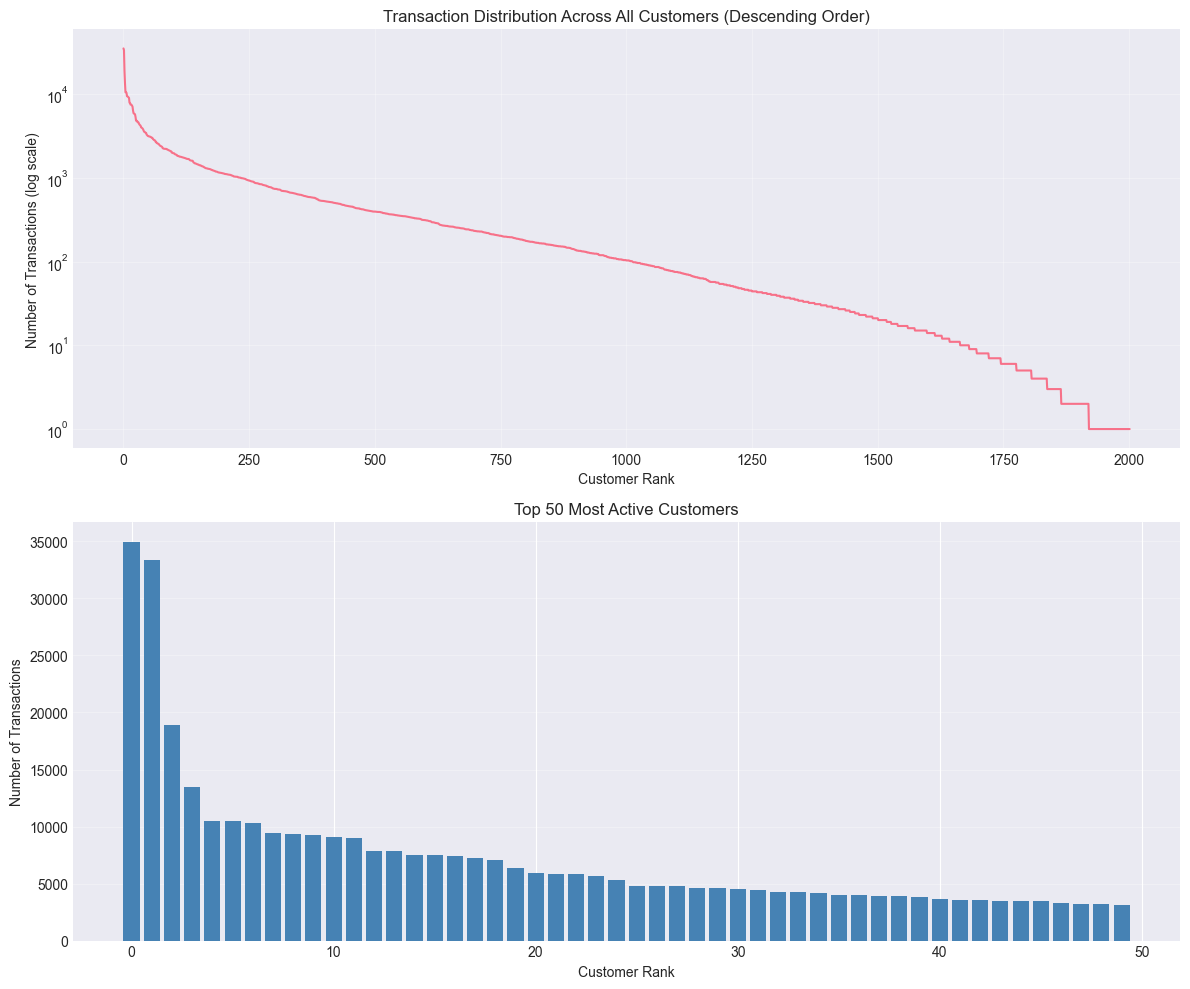

Top 10 customers account for 16.4% of all transactions
Top 20% of customers account for 81.0% of all transactions


In [9]:
customer_activity = plot_customer_activity(df)


Loading transaction data...
Total transactions loaded: 975,955
Date range: 2017-01-01 08:32:26.307000+00:00 to 2020-03-17 00:08:21.430000+00:00
Unique customers: 2,002
Unique products: 50

=== Data Quality Analysis ===
Missing values:
customer_id    0
product_id     0
date           0
year           0
month          0
quarter        0
year_month     0
dtype: int64

Duplicate transactions: 3

=== Transaction Frequency ===
Transactions per customer:
  Mean: 487.49
  Median: 103.00
  Max: 34963
  Min: 1

=== Creating Customer Activity Plot ===


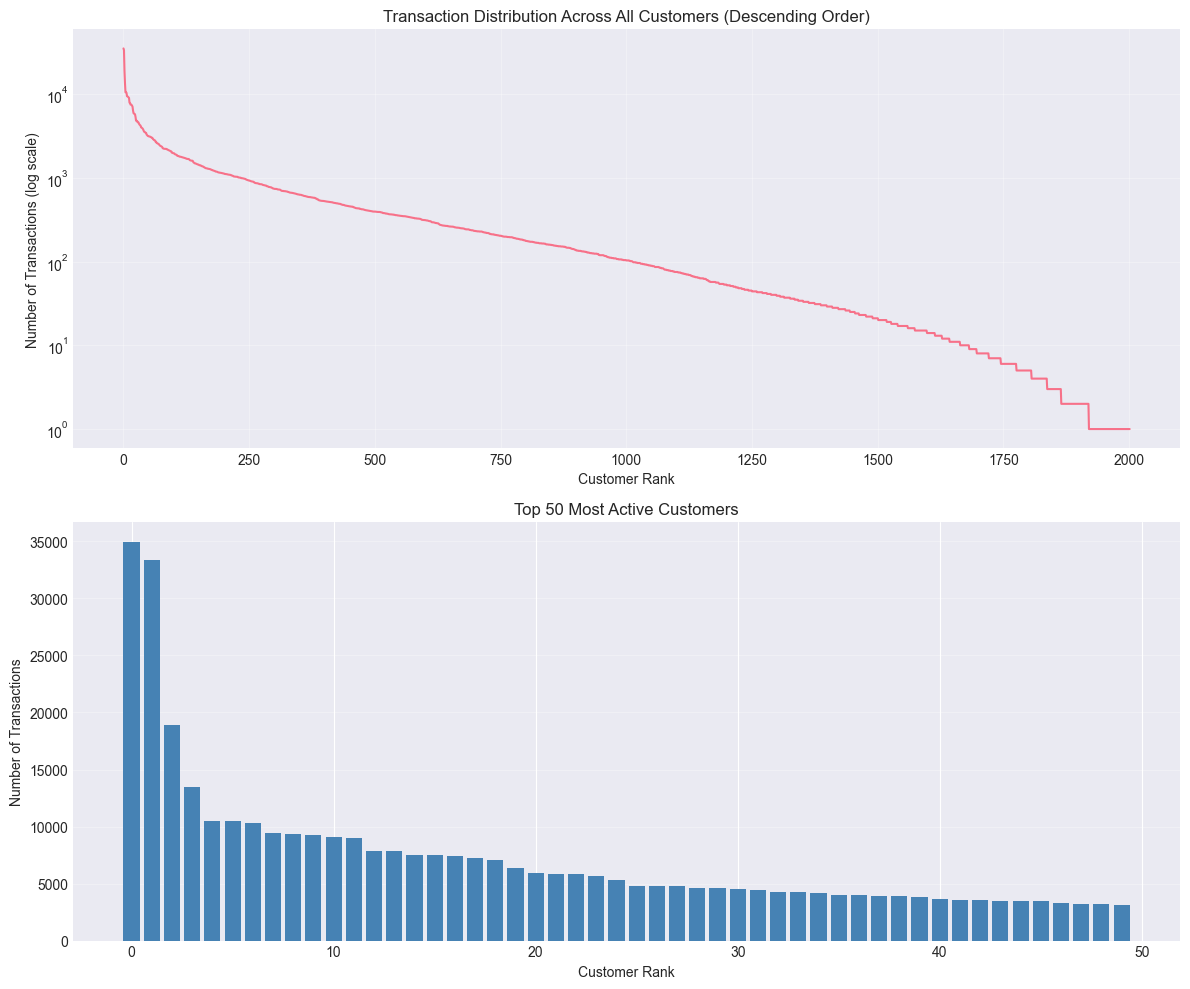

Top 10 customers account for 16.4% of all transactions
Top 20% of customers account for 81.0% of all transactions

=== Most popular products in 2018 ===
product_id
Renault       57052
Volkswagen    28590
Peugeot       24260
Opel          21415
Audi          18121
Name: count, dtype: int64

=== Product Monthly Frequency for Renault in 2018 ===


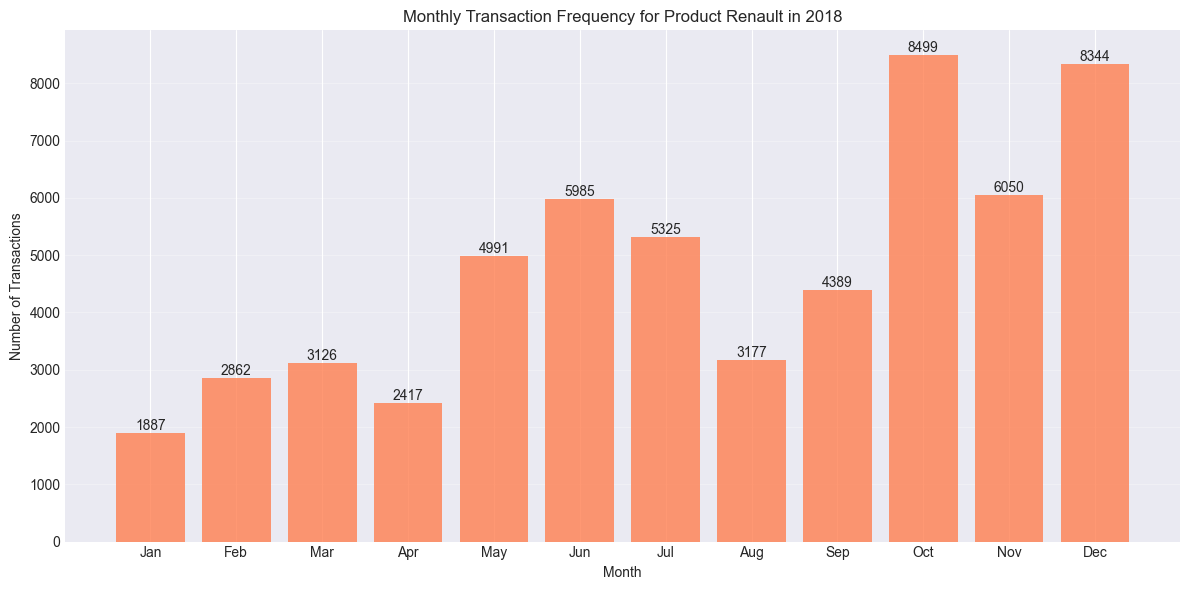

Total transactions in 2018: 57052
Average monthly transactions: 4754.33
Peak month: 10 with 8499 transactions

=== Top Products and Seasonality Analysis ===


TypeError: Invalid comparison between dtype=datetime64[ns, UTC] and Timestamp

In [ ]:

def analyze_top_products_and_seasonality(df):
    """
    Analyze top 5 products over last 6 months and check for seasonality.
    This addresses requirement #4.
    """
    print("\n=== Top Products and Seasonality Analysis ===")
    
    # For each month, calculate top 5 products over previous 6 months
    results = []
    
    # Get unique year-month combinations
    unique_months = df['year_month'].unique()
    unique_months = sorted(unique_months)[6:]  # Start from 7th month to have 6 months history
    
    for current_month in unique_months[-12:]:  # Analyze last 12 months
        # Get last 6 months of data
        end_date = current_month.to_timestamp() + pd.offsets.MonthEnd(0)
        start_date = end_date - pd.DateOffset(months=6)
        
        mask = (df['date'] > start_date) & (df['date'] <= end_date)
        period_data = df[mask]
        
        # Get top 5 products
        top_products = period_data['product_id'].value_counts().head(5)
        
        for rank, (product, count) in enumerate(top_products.items(), 1):
            results.append({
                'month': current_month,
                'rank': rank,
                'product_id': product,
                'transaction_count': count
            })
    
    results_df = pd.DataFrame(results)
    
    # Visualize top products over time
    plt.figure(figsize=(14, 8))
    
    # Get the most frequent top products
    top_products_overall = results_df['product_id'].value_counts().head(10).index
    
    for product in top_products_overall:
        product_data = results_df[results_df['product_id'] == product]
        plt.plot(product_data['month'].astype(str), 
                product_data['transaction_count'], 
                marker='o', label=f'Product {product}', linewidth=2)
    
    plt.xlabel('Month')
    plt.ylabel('Transaction Count (6-month rolling)')
    plt.title('Top Products Transaction Trends (6-month Rolling Window)')
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('plots/top_products_trends.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Analyze seasonality
    print("\n=== Seasonality Analysis ===")
    monthly_total = df.groupby(['year', 'month']).size().reset_index(name='count')
    
    # Calculate average by month across years
    seasonal_pattern = monthly_total.groupby('month')['count'].agg(['mean', 'std'])
    
    plt.figure(figsize=(12, 6))
    x = range(1, 13)
    plt.bar(x, seasonal_pattern['mean'], yerr=seasonal_pattern['std'], 
            capsize=5, color='lightblue', edgecolor='navy', alpha=0.7)
    plt.xlabel('Month')
    plt.ylabel('Average Number of Transactions')
    plt.title('Seasonal Pattern in Transaction Volume')
    plt.xticks(x, ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig('plots/seasonality_pattern.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Statistical test for seasonality
    from scipy import stats
    f_stat, p_value = stats.f_oneway(*[monthly_total[monthly_total['month'] == m]['count'].values 
                                       for m in range(1, 13)])
    print(f"ANOVA test for seasonality: F-statistic = {f_stat:.4f}, p-value = {p_value:.4f}")
    if p_value < 0.05:
        print("Significant seasonality detected in the data!")
    else:
        print("No significant seasonality detected.")
    
    return results_df



In [11]:
popular_products = df[df['year'] == 2018]['product_id'].value_counts().head(5)
print("\n=== Most popular products in 2018 ===")
print(popular_products)



=== Most popular products in 2018 ===
product_id
Renault       57052
Volkswagen    28590
Peugeot       24260
Opel          21415
Audi          18121
Name: count, dtype: int64


In [ ]:
def additional_interesting_analyses(df):
    """
    Perform additional interesting analyses on the dataset.
    This addresses the "other interesting questions" requirement.
    """
    print("\n=== Additional Interesting Analyses ===")
    
    # 1. Customer Lifecycle Analysis
    print("\n1. Customer Lifecycle Analysis")
    customer_lifecycle = df.groupby('customer_id')['date'].agg(['min', 'max'])
    customer_lifecycle['lifespan_days'] = (customer_lifecycle['max'] - customer_lifecycle['min']).dt.days
    customer_lifecycle['lifespan_months'] = customer_lifecycle['lifespan_days'] / 30
    
    plt.figure(figsize=(12, 6))
    plt.hist(customer_lifecycle['lifespan_months'], bins=50, color='green', alpha=0.7, edgecolor='darkgreen')
    plt.xlabel('Customer Lifespan (months)')
    plt.ylabel('Number of Customers')
    plt.title('Distribution of Customer Lifespans')
    plt.axvline(customer_lifecycle['lifespan_months'].mean(), color='red', 
                linestyle='--', label=f'Mean: {customer_lifecycle["lifespan_months"].mean():.1f} months')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('plots/customer_lifecycle.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 2. Product Diversity by Customer Segment
    print("\n2. Product Diversity Analysis")
    customer_stats = df.groupby('customer_id').agg({
        'product_id': 'nunique',
        'date': 'count'
    }).rename(columns={'product_id': 'unique_products', 'date': 'total_transactions'})
    
    # Segment customers
    customer_stats['segment'] = pd.qcut(customer_stats['total_transactions'], 
                                       q=[0, 0.25, 0.75, 1], 
                                       labels=['Low', 'Medium', 'High'])
    
    plt.figure(figsize=(10, 6))
    customer_stats.boxplot(column='unique_products', by='segment', grid=False)
    plt.suptitle('')
    plt.title('Product Diversity by Customer Segment')
    plt.ylabel('Number of Unique Products Purchased')
    plt.xlabel('Customer Activity Segment')
    plt.tight_layout()
    plt.savefig('plots/product_diversity_by_segment.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 3. Day of Week Analysis
    print("\n3. Transaction Pattern by Day of Week")
    df['day_of_week'] = df['date'].dt.day_name()
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    
    day_counts = df['day_of_week'].value_counts().reindex(day_order)
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(range(7), day_counts.values, color='purple', alpha=0.7)
    plt.xticks(range(7), day_order, rotation=45)
    plt.xlabel('Day of Week')
    plt.ylabel('Number of Transactions')
    plt.title('Transaction Volume by Day of Week')
    
    # Add percentage labels
    total = day_counts.sum()
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height/total*100:.1f}%', ha='center', va='bottom')
    
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.savefig('plots/transactions_by_day_of_week.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return customer_stats


In [6]:
def plot_product_monthly_frequency(df, product_id, year=2018):
    """
    Plot transaction frequency per month for a specific product in 2018.
    This addresses requirement #2.
    """
    print(f"\n=== Product Monthly Frequency for {product_id} in {year} ===")
    
    # Filter for specific product and year
    product_df = df[(df['product_id'] == product_id) & (df['year'] == year)]
    
    if len(product_df) == 0:
        print(f"No transactions found for product {product_id} in {year}")
        # Try to find a popular product as alternative
        popular_products = df[df['year'] == year]['product_id'].value_counts().head(10)
        print(f"Most popular products in {year}:")
        print(popular_products)
        return
    
    # Group by month
    monthly_freq = product_df.groupby('month').size().reindex(range(1, 13), fill_value=0)
    
    # Create plot
    plt.figure(figsize=(12, 6))
    bars = plt.bar(monthly_freq.index, monthly_freq.values, color='coral', alpha=0.8)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height)}', ha='center', va='bottom')
    
    plt.xlabel('Month')
    plt.ylabel('Number of Transactions')
    plt.title(f'Monthly Transaction Frequency for Product {product_id} in {year}')
    plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig(f'plots/product_{product_id}_monthly_{year}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Calculate statistics
    print(f"Total transactions in {year}: {monthly_freq.sum()}")
    print(f"Average monthly transactions: {monthly_freq.mean():.2f}")
    print(f"Peak month: {monthly_freq.idxmax()} with {monthly_freq.max()} transactions")

In [15]:
# Top products and seasonality analysis
top_products_df = analyze_top_products_and_seasonality(df)
top_products_df



=== Top Products and Seasonality Analysis ===


TypeError: Invalid comparison between dtype=datetime64[ns, UTC] and Timestamp

In [ ]:
    # Additional interesting analyses
    customer_stats = additional_interesting_analyses(df)
    
    # Save processed data for modeling
    df.to_csv('data/processed_transactions.csv', index=False)
    print("\n=== Analysis Complete ===")
    print("All plots saved in 'plots/' directory")
    print("Processed data saved as 'data/processed_transactions.csv'")

Loading transaction data...
Total transactions loaded: 975,955
Date range: 2017-01-01 08:32:26.307000+00:00 to 2020-03-17 00:08:21.430000+00:00
Unique customers: 2,002
Unique products: 50

=== Data Quality Analysis ===
Missing values:
customer_id    0
product_id     0
date           0
year           0
month          0
quarter        0
year_month     0
dtype: int64

Duplicate transactions: 3

=== Transaction Frequency ===
Transactions per customer:
  Mean: 487.49
  Median: 103.00
  Max: 34963
  Min: 1

=== Creating Customer Activity Plot ===


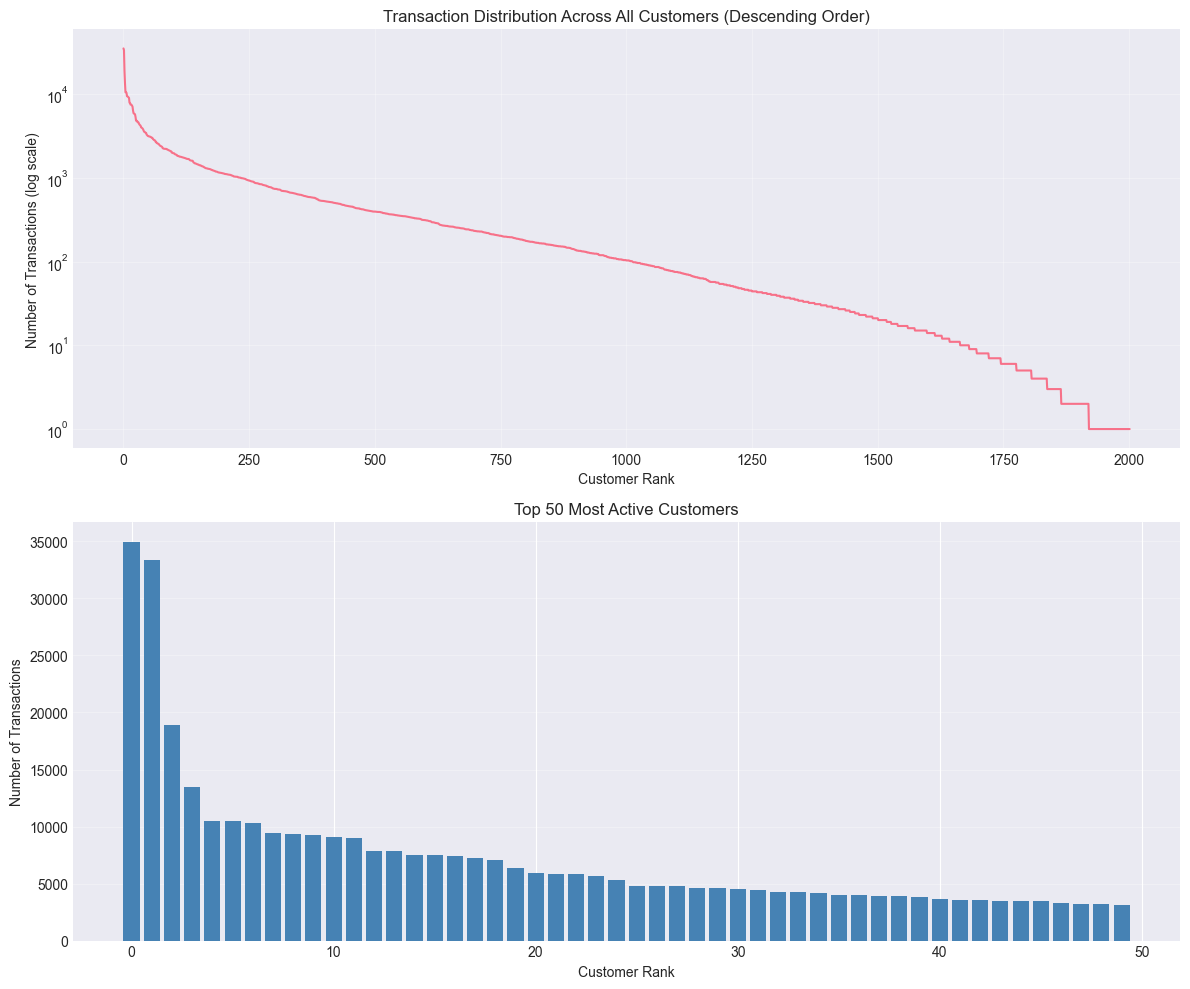

Top 10 customers account for 16.4% of all transactions
Top 20% of customers account for 81.0% of all transactions

=== Most popular products in 2018 ===
product_id
Renault       57052
Volkswagen    28590
Peugeot       24260
Opel          21415
Audi          18121
Name: count, dtype: int64

=== Product Monthly Frequency for Renault in 2018 ===


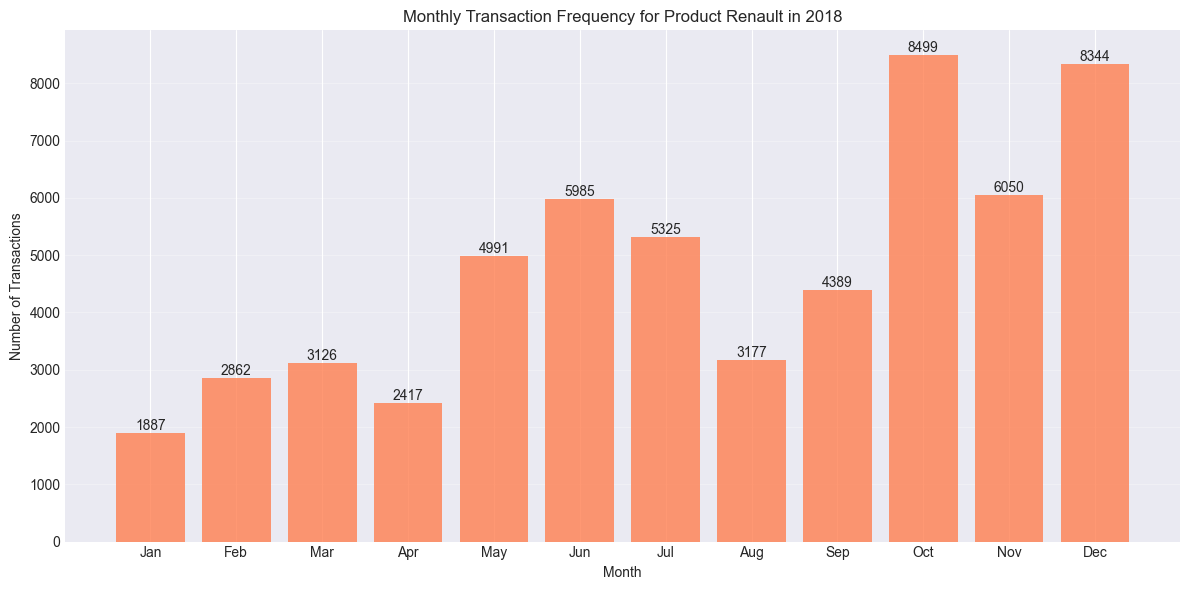

Total transactions in 2018: 57052
Average monthly transactions: 4754.33
Peak month: 10 with 8499 transactions

=== Top Products and Seasonality Analysis ===


TypeError: Invalid comparison between dtype=datetime64[ns, UTC] and Timestamp

In [18]:
"""
Sales Forecast and Analysis - Complete Solution
Author: [Your Name]
Date: 2025-01-06

This project analyzes customer transaction data to understand behavior patterns
and predict future transactions. It includes EDA, visualizations, feature engineering,
and multiple ML models.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# ==================== 1. DATA LOADING AND CLEANING ====================

def load_and_clean_data():
    """
    Load transaction data from CSV files and perform initial cleaning.
    
    Returns:
    --------
    pd.DataFrame: Cleaned and combined transaction data
    """
    print("Loading transaction data...")
    
    # Load both CSV files
    df1 = pd.read_csv('dataset/transactions_1.csv')
    df2 = pd.read_csv('dataset/transactions_2.csv')
    
    # Combine datasets
    df = pd.concat([df1, df2], ignore_index=True)
    
    # Drop the unnamed index column
    if df.columns[0] == 'Unnamed: 0' or df.columns[0] == '':
        df = df.drop(columns=df.columns[0])
    
    # Ensure proper data types
    df['date'] = pd.to_datetime(df['date'])
    df['customer_id'] = df['customer_id'].astype(int)
    df['product_id'] = df['product_id'].astype(str)
    
    # Sort by date
    df = df.sort_values('date').reset_index(drop=True)
    
    # Add time-based features for analysis
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['quarter'] = df['date'].dt.quarter
    df['year_month'] = df['date'].dt.to_period('M')
    
    print(f"Total transactions loaded: {len(df):,}")
    print(f"Date range: {df['date'].min()} to {df['date'].max()}")
    print(f"Unique customers: {df['customer_id'].nunique():,}")
    print(f"Unique products: {df['product_id'].nunique():,}")
    
    return df

# ==================== 2. EXPLORATORY DATA ANALYSIS ====================

def analyze_data_quality(df):
    """Analyze data quality and basic statistics."""
    print("\n=== Data Quality Analysis ===")
    print(f"Missing values:\n{df.isnull().sum()}")
    print(f"\nDuplicate transactions: {df.duplicated().sum()}")
    
    # Transaction frequency analysis
    print("\n=== Transaction Frequency ===")
    txn_per_customer = df.groupby('customer_id').size()
    print(f"Transactions per customer:")
    print(f"  Mean: {txn_per_customer.mean():.2f}")
    print(f"  Median: {txn_per_customer.median():.2f}")
    print(f"  Max: {txn_per_customer.max()}")
    print(f"  Min: {txn_per_customer.min()}")

def plot_customer_activity(df):
    """
    Create ordered plot showing total transactions per customer (descending).
    This addresses requirement #1.
    """
    print("\n=== Creating Customer Activity Plot ===")
    
    # Calculate transactions per customer
    customer_txns = df.groupby('customer_id').size().reset_index(name='transaction_count')
    customer_txns = customer_txns.sort_values('transaction_count', ascending=False)
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Plot 1: All customers (log scale for better visibility)
    ax1.plot(range(len(customer_txns)), customer_txns['transaction_count'].values)
    ax1.set_yscale('log')
    ax1.set_xlabel('Customer Rank')
    ax1.set_ylabel('Number of Transactions (log scale)')
    ax1.set_title('Transaction Distribution Across All Customers (Descending Order)')
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Top 50 customers
    top_50 = customer_txns.head(50)
    ax2.bar(range(len(top_50)), top_50['transaction_count'].values, color='steelblue')
    ax2.set_xlabel('Customer Rank')
    ax2.set_ylabel('Number of Transactions')
    ax2.set_title('Top 50 Most Active Customers')
    ax2.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig('plots/customer_activity_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print insights
    print(f"Top 10 customers account for {customer_txns.head(10)['transaction_count'].sum() / len(df) * 100:.1f}% of all transactions")
    print(f"Top 20% of customers account for {customer_txns.head(int(len(customer_txns)*0.2))['transaction_count'].sum() / len(df) * 100:.1f}% of all transactions")
    
    return customer_txns

def plot_product_monthly_frequency(df, product_id, year=2018):
    """
    Plot transaction frequency per month for a specific product in 2018.
    This addresses requirement #2.
    """
    print(f"\n=== Product Monthly Frequency for {product_id} in {year} ===")
    
    # Filter for specific product and year
    product_df = df[(df['product_id'] == product_id) & (df['year'] == year)]
    
    if len(product_df) == 0:
        print(f"No transactions found for product {product_id} in {year}")
        # Try to find a popular product as alternative
        popular_products = df[df['year'] == year]['product_id'].value_counts().head(10)
        print(f"Most popular products in {year}:")
        print(popular_products)
        return
    
    # Group by month
    monthly_freq = product_df.groupby('month').size().reindex(range(1, 13), fill_value=0)
    
    # Create plot
    plt.figure(figsize=(12, 6))
    bars = plt.bar(monthly_freq.index, monthly_freq.values, color='coral', alpha=0.8)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height)}', ha='center', va='bottom')
    
    plt.xlabel('Month')
    plt.ylabel('Number of Transactions')
    plt.title(f'Monthly Transaction Frequency for Product {product_id} in {year}')
    plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig(f'plots/product_{product_id}_monthly_{year}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Calculate statistics
    print(f"Total transactions in {year}: {monthly_freq.sum()}")
    print(f"Average monthly transactions: {monthly_freq.mean():.2f}")
    print(f"Peak month: {monthly_freq.idxmax()} with {monthly_freq.max()} transactions")

def analyze_top_products_and_seasonality(df):
    """
    Analyze top 5 products over last 6 months and check for seasonality.
    This addresses requirement #4.
    """
    print("\n=== Top Products and Seasonality Analysis ===")
    
    # For each month, calculate top 5 products over previous 6 months
    results = []
    
    # Get unique year-month combinations
    unique_months = df['year_month'].unique()
    unique_months = sorted(unique_months)[6:]  # Start from 7th month to have 6 months history
    
    for current_month in unique_months[-12:]:  # Analyze last 12 months
        # Get last 6 months of data
        end_date = current_month.to_timestamp() + pd.offsets.MonthEnd(0)
        start_date = end_date - pd.DateOffset(months=6)
        
        mask = (df['date'] > start_date) & (df['date'] <= end_date)
        period_data = df[mask]
        
        # Get top 5 products
        top_products = period_data['product_id'].value_counts().head(5)
        
        for rank, (product, count) in enumerate(top_products.items(), 1):
            results.append({
                'month': current_month,
                'rank': rank,
                'product_id': product,
                'transaction_count': count
            })
    
    results_df = pd.DataFrame(results)
    
    # Visualize top products over time
    plt.figure(figsize=(14, 8))
    
    # Get the most frequent top products
    top_products_overall = results_df['product_id'].value_counts().head(10).index
    
    for product in top_products_overall:
        product_data = results_df[results_df['product_id'] == product]
        plt.plot(product_data['month'].astype(str), 
                product_data['transaction_count'], 
                marker='o', label=f'Product {product}', linewidth=2)
    
    plt.xlabel('Month')
    plt.ylabel('Transaction Count (6-month rolling)')
    plt.title('Top Products Transaction Trends (6-month Rolling Window)')
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('plots/top_products_trends.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Analyze seasonality
    print("\n=== Seasonality Analysis ===")
    monthly_total = df.groupby(['year', 'month']).size().reset_index(name='count')
    
    # Calculate average by month across years
    seasonal_pattern = monthly_total.groupby('month')['count'].agg(['mean', 'std'])
    
    plt.figure(figsize=(12, 6))
    x = range(1, 13)
    plt.bar(x, seasonal_pattern['mean'], yerr=seasonal_pattern['std'], 
            capsize=5, color='lightblue', edgecolor='navy', alpha=0.7)
    plt.xlabel('Month')
    plt.ylabel('Average Number of Transactions')
    plt.title('Seasonal Pattern in Transaction Volume')
    plt.xticks(x, ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig('plots/seasonality_pattern.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Statistical test for seasonality
    from scipy import stats
    f_stat, p_value = stats.f_oneway(*[monthly_total[monthly_total['month'] == m]['count'].values 
                                       for m in range(1, 13)])
    print(f"ANOVA test for seasonality: F-statistic = {f_stat:.4f}, p-value = {p_value:.4f}")
    if p_value < 0.05:
        print("Significant seasonality detected in the data!")
    else:
        print("No significant seasonality detected.")
    
    return results_df

def additional_interesting_analyses(df):
    """
    Perform additional interesting analyses on the dataset.
    This addresses the "other interesting questions" requirement.
    """
    print("\n=== Additional Interesting Analyses ===")
    
    # 1. Customer Lifecycle Analysis
    print("\n1. Customer Lifecycle Analysis")
    customer_lifecycle = df.groupby('customer_id')['date'].agg(['min', 'max'])
    customer_lifecycle['lifespan_days'] = (customer_lifecycle['max'] - customer_lifecycle['min']).dt.days
    customer_lifecycle['lifespan_months'] = customer_lifecycle['lifespan_days'] / 30
    
    plt.figure(figsize=(12, 6))
    plt.hist(customer_lifecycle['lifespan_months'], bins=50, color='green', alpha=0.7, edgecolor='darkgreen')
    plt.xlabel('Customer Lifespan (months)')
    plt.ylabel('Number of Customers')
    plt.title('Distribution of Customer Lifespans')
    plt.axvline(customer_lifecycle['lifespan_months'].mean(), color='red', 
                linestyle='--', label=f'Mean: {customer_lifecycle["lifespan_months"].mean():.1f} months')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('plots/customer_lifecycle.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 2. Product Diversity by Customer Segment
    print("\n2. Product Diversity Analysis")
    customer_stats = df.groupby('customer_id').agg({
        'product_id': 'nunique',
        'date': 'count'
    }).rename(columns={'product_id': 'unique_products', 'date': 'total_transactions'})
    
    # Segment customers
    customer_stats['segment'] = pd.qcut(customer_stats['total_transactions'], 
                                       q=[0, 0.25, 0.75, 1], 
                                       labels=['Low', 'Medium', 'High'])
    
    plt.figure(figsize=(10, 6))
    customer_stats.boxplot(column='unique_products', by='segment', grid=False)
    plt.suptitle('')
    plt.title('Product Diversity by Customer Segment')
    plt.ylabel('Number of Unique Products Purchased')
    plt.xlabel('Customer Activity Segment')
    plt.tight_layout()
    plt.savefig('plots/product_diversity_by_segment.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 3. Day of Week Analysis
    print("\n3. Transaction Pattern by Day of Week")
    df['day_of_week'] = df['date'].dt.day_name()
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    
    day_counts = df['day_of_week'].value_counts().reindex(day_order)
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(range(7), day_counts.values, color='purple', alpha=0.7)
    plt.xticks(range(7), day_order, rotation=45)
    plt.xlabel('Day of Week')
    plt.ylabel('Number of Transactions')
    plt.title('Transaction Volume by Day of Week')
    
    # Add percentage labels
    total = day_counts.sum()
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height/total*100:.1f}%', ha='center', va='bottom')
    
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.savefig('plots/transactions_by_day_of_week.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return customer_stats

# ==================== 3. MAIN EXECUTION ====================

def main():
    """Main execution function."""
    # Create plots directory
    import os
    os.makedirs('plots', exist_ok=True)
    
    # Load data
    df = load_and_clean_data()
    
    # Data quality analysis
    analyze_data_quality(df)
    
    # Required visualizations
    customer_activity = plot_customer_activity(df)
    
    # Plot for a popular product (you can change this to any product_id)
    # First, let's find popular products
    popular_products = df[df['year'] == 2018]['product_id'].value_counts().head(5)
    print("\n=== Most popular products in 2018 ===")
    print(popular_products)
    
    # Plot for the most popular product
    plot_product_monthly_frequency(df, popular_products.index[0], 2018)
    
    # Top products and seasonality analysis
    top_products_df = analyze_top_products_and_seasonality(df)
    
    # Additional interesting analyses
    customer_stats = additional_interesting_analyses(df)
    
    # Save processed data for modeling
    df.to_csv('data/processed_transactions.csv', index=False)
    print("\n=== Analysis Complete ===")
    print("All plots saved in 'plots/' directory")
    print("Processed data saved as 'data/processed_transactions.csv'")
    
    return df

if __name__ == "__main__":
    df = main()